# 1. Linear Regression

solve problem:

$y^{(i)} = \theta^T x^{(i)} + \epsilon^{(i)}$

# 1.1 Assumptions
- errors ~ $N(0, \delta^2)$, that is, $p(\epsilon^{(i)}) = \frac{1}{\sqrt {2\pi} \delta} exp(-\frac{(\epsilon ^{(i)})^2}{2\delta^2})$
    - with rearangement, we have $p(y^{(i)}|x^{(i); \theta}) = \frac{1}{\sqrt {2\pi} \delta} exp(-\frac{(y^{(i)} - \theta^Tx^{(i)})^2}{2\delta^2})$
- samples: independent

## 1.2 Likelihood Function

**Likelihodd Function**:

\begin{equation}

    L(\theta) = p(y^{(1,...,m)} | x^{(1,...,m)}; \theta) = \Pi_{i=1}^m p(y^i|x^i, \theta)
    
\end{equation}

**Notes**
- what parameter can predict the given target when combined with given features -> purpose of maximum likelihood
- the maximum probability that the parameter $\theta$ can make ALL the prediction matches ALL the measurement
- due to the independency of samples, the above equation holds.


**Log-likelihood Function**

\begin{align}
 log L(\theta) &= \sum_{i=1}^{m} log (p(y^i|x^i; \theta)) \\
    &= \sum_{i=1}^{m} log (\frac{1}{\sqrt {2\pi} \delta} exp(-\frac{(y^i - \theta^T(x^i)^2}{2\delta^2})) \\
    &= m log (\frac{1}{\sqrt{2\pi}\delta}) - \frac{1}{\delta^2} \cdot \frac{1}{2} \sum_{i=0}^{m} (y^i - \theta^Tx^i)^2 \\
    &= constant - \frac{1}{\delta^2} \cdot J(\theta)
\end{align}

where $constant$ is a constant value, and $J(\theta)$ is typicall known as the least-sqaures cost function, or mean square errors.

**Notes**
- easy calculation by changing production to additions.
- maximizing the log-likelihood function with respect to $\theta$ is equivalent to minimizing the means squared error. These two have different values but the same location of the optimum.


## 1.3 Propeties of Maximum Likelihood 
The main appeal of the maximum likelihood estimator is that it can be shown to be the best estimator asymptotically, as the number of examples $m \rightarrow \infty$, in terms of its rate of convergence as `m` increases.

Under appropriate conditions, the maximum likelihood estimator has the property of consistency, meaning that as the number of training examples approaches inﬁnity, the maximum likelihood estimate of a parameter
converges to the true value of the parameter. These conditions are as follows:
- The true distribution $p_{data}$ must lie within the model family $p_{model}(·;θ)$.
Otherwise, no estimator can recover $p_{data}$.
- The true distribution $p_{data}$ must be identiﬁable, meaning that there exists a unique value of θ that maximizes the likelihood function $p_{data}(·;θ)$. Otherwise, no estimator can recover $p_{data}$.

## 1.4 Ordinary Linear Regression
Ordinary linear regression is simply a dense neural network with a single neuron and no activation function. The neuron computes the weighted sum of its inputs and adds a bias term. The weights and bias are the parameters that the model will learn.

In [1]:
import jax
import jax.numpy as jnp
from jax import random, jit
from flax.core import freeze, unfreeze
import flax.linen as nn

class Linear(nn.Module):
    in_features: int
    out_features: int
    kernel_init: nn.initializers.Initializer = nn.initializers.xavier_normal()
    bias_init: nn.initializers.Initializer = nn.initializers.zeros
    
    @nn.compact
    def __call__(self, x):
        w = self.param('w', # name of the parameter 
                       self.kernel_init, # initialization
                       (self.in_features, self.out_features) # shape of the parameter
                       ) 
        b = self.param('b', self.bias_init, (self.out_features,))
        return jnp.dot(x, w) + b

In [2]:
# get some data
from sklearn.datasets import make_regression 

X, y, true_weights = make_regression(
    n_samples=100,
    n_features=100,
    n_informative=10,
    noise=8,
    coef=True,
    random_state=42,
)
# This is very critical to avoid implicit broadcasting
y = y.reshape(-1, 1)

In [3]:
import optax # for optimizers

# define the linear model
lr = Linear(in_features=100, out_features=1)

# initialize the model
key1, key2 = random.split(random.PRNGKey(0), 2)
params = lr.init(key1, X)

# define the loss function
def loss_fcn(params, x, y):
    
    y_pred = lr.apply(params, x)
    #print(y.shape, y_pred.shape)
    
    return jnp.mean((y_pred - y)**2)

# define optimizer: we can call existing optimizer from flax.optim
losses = []
nepochs = 5000

# This code is a simple SGD
#for epoch in range(nepochs):
#    # compute the loss and the gradients
#    loss, grads = jit(jax.value_and_grad(loss_fcn))(params, X, y)
#    losses.append(loss)
#    # update the parameters
#    params = jax.tree_map(lambda p, g: p - 0.01 * g, params, grads)
    

#y_pred = lr.apply(params, X)


# Lets call existing optimizer from flax.optim
@jax.jit
def update(params, opt_state, X, y):
    loss, grads = jax.value_and_grad(loss_fcn)(params, X, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

optimizer = optax.sgd(learning_rate=1e-01)
opt_state = optimizer.init(params)
for epoch in range(nepochs):
    loss, params, opt_state = update(params, opt_state, X, y)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, loss: {loss}')


2023-04-23 22:00:19.829219: W external/xla/xla/service/gpu/nvptx_compiler.cc:564] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.1.105). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Epoch 0, loss: 20148.482421875
Epoch 100, loss: 17.540294647216797
Epoch 200, loss: 5.88097620010376
Epoch 300, loss: 3.2285473346710205
Epoch 400, loss: 2.1267364025115967
Epoch 500, loss: 1.5518691539764404
Epoch 600, loss: 1.21358323097229
Epoch 700, loss: 0.9975888729095459
Epoch 800, loss: 0.850727379322052
Epoch 900, loss: 0.7457789182662964
Epoch 1000, loss: 0.6677569150924683
Epoch 1100, loss: 0.607931911945343
Epoch 1200, loss: 0.5608958601951599
Epoch 1300, loss: 0.5231589674949646
Epoch 1400, loss: 0.49236541986465454
Epoch 1500, loss: 0.46687567234039307
Epoch 1600, loss: 0.44549643993377686
Epoch 1700, loss: 0.4273681938648224
Epoch 1800, loss: 0.41183581948280334
Epoch 1900, loss: 0.398405522108078
Epoch 2000, loss: 0.386691689491272
Epoch 2100, loss: 0.3763965964317322
Epoch 2200, loss: 0.3672841489315033
Epoch 2300, loss: 0.35916900634765625
Epoch 2400, loss: 0.35189521312713623
Epoch 2500, loss: 0.3453378975391388
Epoch 2600, loss: 0.339396208524704
Epoch 2700, loss: 0

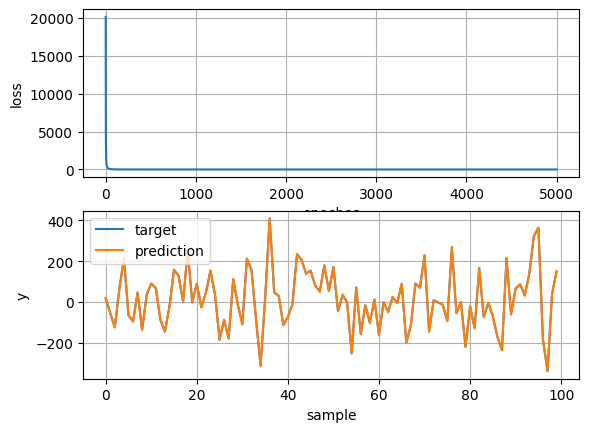

In [4]:
y_pred = lr.apply(params, X)

# plot the loss
import matplotlib 
from matplotlib import pyplot as plt

plt.figure()
plt.subplot(2,1,1)
plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("epoches")
plt.grid()

plt.subplot(2,1,2)
plt.plot(y, label="target")
plt.plot(y_pred, label="prediction")
plt.ylabel("y")
plt.xlabel("sample")
plt.legend()
plt.grid()


## 1.5 Ridge Regression

Ridge regression addresses some of the problems of the ordinary linear regression by imposing a penalty on the size of the weights in the form of a $L2-norm$. The ridge regression cost function is given by:

\begin{equation}
    J(\theta) = \frac{1}{2} \sum_{i=1}^{m} (y^{(i)} - \theta^Tx^{(i)})^2 + \frac{\lambda}{2} \sum_{j=1}^{n} \theta_j^2
\end{equation}

This is equivalent to adding a $L2$ regularization term to the cost function of ordinary linear regression. The hyperparameter $\lambda$ controls the amount of regularization. For $\lambda = 0$, we get back the ordinary linear regression. For very large values of $\lambda$, the weights end up very close to zero, and the result is a flat line going through the data’s mean.

**Notes**
- the larger $\lambda$ on the penalty term, for a minimizaiton problem, the smaller the weights are. This is called shrinkage.
- useful when colinear features exist in the dataset, which means that some features are highly correlated with each other. In such cases, the weights can become numerically unstable, and a small change in the data can cause the weights to take large swings. By imposing a penalty on their size, this instability is reduced.
- the implementation is the same as ordinay linear regression, except that the loss function is different.


## 1.6 LASSO Regression

The LASSO regression is another form of regularized linear regression that imposes a $L1$ regularization penalty instead of a $L2$ penalty. The LASSO regression cost function is given by:

\begin{equation}
    J(\theta) = \frac{1}{2} \sum_{i=1}^{m} (y^{(i)} - \theta^Tx^{(i)})^2 + \lambda \sum_{j=1}^{n} |\theta_j|
\end{equation}

**Notes**
- Lasso prefers sparse solutions, that is, solutions with fewer nonzero weights. This is because the $L1$ penalty tends to force weights to zero for many features, especially when the data is highly colinear.
- Lasso is useful when we have a large number of features, because it automatically performs feature selection and outputs a sparse model.
- the implementation is the same as ordinay linear regression, except that the loss function is different.
